In [ ]:
!pip uninstall -y pyarrow datasets
!pip install -U pyarrow datasets
!pip install -q -U peft
!pip install -q -U trl
!pip install -q -U bitsandbytes
!pip install -U transformers accelerate

Found existing installation: pyarrow 18.1.0
Uninstalling pyarrow-18.1.0:
  Successfully uninstalled pyarrow-18.1.0
Found existing installation: datasets 4.0.0
Uninstalling datasets-4.0.0:
  Successfully uninstalled datasets-4.0.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.2/515.2 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 530.9/530.9 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 134.2 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 5.0.0
    Uninstalling transformers-5.0.0:
      Successfully uninstalled transformers-5.0.0


In [ ]:
import os
os.kill(os.getpid(), 9)

# Synthetic Data Generation and Prompt Construction

In [ ]:
import numpy as np
import pandas as pd
import random

# =========================================================
# Reproducibility
# =========================================================
np.random.seed(42)
random.seed(42)

# =========================================================
# Configuration
# =========================================================
N_STUDENTS = 30
SAMPLES_PER_STUDENT = 20
SUBJECTS = ["English", "Health", "Language", "Maths", "Politics", "Science"]
LABELS = ["engagement", "neutral", "disengagement"]

# =========================================================
# Temporal generator
# =========================================================
def generate_temporal_values(mean, std, low, high):
    values = np.random.normal(mean, std, 10)
    return np.clip(values, low, high)

# =========================================================
# Label-dependent parameter settings
# =========================================================
PARAMS = {
    "engagement": {
        "ACC": (38, 10),
        "HR": (88, 10),
        "EDA": (0.45, 0.10),
        "TEMP": (30.3, 0.25)
    },
    "neutral": {
        "ACC": (28, 14),
        "HR": (80, 12),
        "EDA": (0.55, 0.12),
        "TEMP": (30.2, 0.30)
    },
    "disengagement": {
        "ACC": (18, 18),
        "HR": (72, 12),
        "EDA": (0.75, 0.15),  # ← Disengagement has higher EDA
        "TEMP": (30.1, 0.35)
    }
}

# =========================================================
# Data generation
# =========================================================
statistical_rows = []

for pid in range(1, N_STUDENTS + 1):
    gender = random.choice(["Male", "Female"])
    age = random.randint(15, 18)

    for _ in range(SAMPLES_PER_STUDENT):
        class_id = random.randint(100, 160)
        subject = random.choice(SUBJECTS)
        label = random.choice(LABELS)

        key = f"{class_id}_{pid}"
        p = PARAMS[label]

        # Temporal values (10-min window)
        ACC = generate_temporal_values(p["ACC"][0], p["ACC"][1], -50, 80)
        HR  = generate_temporal_values(p["HR"][0],  p["HR"][1],  60, 120)
        EDA = generate_temporal_values(p["EDA"][0], p["EDA"][1], 0.2, 1.2)
        TEMP = generate_temporal_values(p["TEMP"][0], p["TEMP"][1], 29.5, 31.0)

        statistical_rows.append({
            "Key": key,
            "ACC_mean": ACC.mean(),
            "ACC_sd": ACC.std(),
            "ACC_max": ACC.max(),
            "ACC_min": ACC.min(),
            "HR_mean": HR.mean(),
            "HR_sd": HR.std(),
            "HR_max": HR.max(),
            "HR_min": HR.min(),
            "EDA_mean": EDA.mean(),
            "EDA_sd": EDA.std(),
            "EDA_max": EDA.max(),
            "EDA_min": EDA.min(),
            "TEMP_mean": TEMP.mean(),
            "TEMP_sd": TEMP.std(),
            "TEMP_max": TEMP.max(),
            "TEMP_min": TEMP.min(),
            "Class_id": class_id,
            "Subject": subject,
            "Pid": pid,
            "Gender": gender,
            "Age": age,
            "label": label
        })

# =========================================================
# Save dataset
# =========================================================
df = pd.DataFrame(statistical_rows)
df.to_csv("data_statistical.csv", index=False)

print("data_statistical.csv generated successfully.")


data_statistical.csv generated successfully.


In [ ]:
import pandas as pd

# =========================================================
# Load statistical feature dataset
# =========================================================
df = pd.read_csv('data_statistical.csv')

# =========================================================
# Construct natural language prompts for LLM input
# =========================================================
df['text'] = df.apply(
    lambda row: (
        f"The following data were obtained from one {row['Gender']} student {row['Pid']} "
        f"of {row['Subject']} class {row['Class_id']} in any 10 minutes of 80. "
        f"The statistics (mean, standard deviation, maximum, and minimum values) "
        f"of heart rate (HR), acceleration (ACC), electrodermal activity (EDA), "
        f"and skin temperature (TEMP) per minute are as follows:\n"
        f"HR: mean:{row['HR_mean']}, sd:{row['HR_sd']}, max:{row['HR_max']}, min:{row['HR_min']}\n"
        f"ACC: mean:{row['ACC_mean']}, sd:{row['ACC_sd']}, max:{row['ACC_max']}, min:{row['ACC_min']}\n"
        f"EDA: mean:{row['EDA_mean']}, sd:{row['EDA_sd']}, max:{row['EDA_max']}, min:{row['EDA_min']}\n"
        f"TEMP: mean:{row['TEMP_mean']}, sd:{row['TEMP_sd']}, max:{row['TEMP_max']}, min:{row['TEMP_min']}"
    ),
    axis=1
)

# =========================================================
# Select columns required for LLM-based classification
# =========================================================
df_llm = df[['label', 'text', 'Key']]
df_llm.to_csv('data_statistical_llm.csv', index=False)

df_llm.head()


,label,text,Key
0,engagement,The following data were obtained from one Male...,147_1
1,disengagement,The following data were obtained from one Male...,114_1
2,disengagement,The following data were obtained from one Male...,106_1
3,engagement,The following data were obtained from one Male...,157_1
4,engagement,The following data were obtained from one Male...,137_1


# LLM-Based Classification of Student Engagement from Physiological Features

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import BitsAndBytesConfig
import torch
import numpy as np
import pandas as pd
import os
import bitsandbytes as bnb
from datasets import Dataset
from sklearn.model_selection import train_test_split


# =========================
# Load dataset
# =========================
filename = "data_statistical_llm.csv"
df = pd.read_csv(filename, encoding="utf-8", encoding_errors="replace")

# Name of the target label used in prompts
label_name = "engagement level"

# Containers for train / test / evaluation splits
X_train = []
X_test = []
X_eval = []


# =========================
# Stratified split by Key to avoid data leakage
# Each Key appears in only one split
# =========================
for sentiment in ["engagement", "disengagement", "neutral"]:
    subset = df[df.label == sentiment]
    unique_keys = subset["Key"].unique()

    # Randomly shuffle and split keys
    train_keys, temp_keys = train_test_split(
        unique_keys, train_size=0.5, random_state=42
    )
    test_keys, eval_keys = train_test_split(
        temp_keys, test_size=0.5, random_state=42
    )

    # Select data based on Key
    train_data = subset[subset["Key"].isin(train_keys)]
    test_data = subset[subset["Key"].isin(test_keys)]
    eval_data = subset[subset["Key"].isin(eval_keys)]

    X_train.append(train_data)
    X_test.append(test_data)
    X_eval.append(eval_data)

# Concatenate and shuffle training data
X_train = pd.concat(X_train).sample(frac=1, random_state=10).reset_index(drop=True)
X_test = pd.concat(X_test).reset_index(drop=True)
X_eval = pd.concat(X_eval).reset_index(drop=True)


# =========================
# Prompt generation functions
# =========================
def generate_prompt(data_point):
    """
    Generate a supervised fine-tuning prompt including the correct label.
    """
    return f"""The {label_name} of the following phrase: '{data_point["text"]}' is
            \n\n Engagement
            \n Disengagement
            \n Neutral
            \n Cannot be determined
            \n\nSolution: The correct option is {data_point["label"]}""".strip()


def generate_test_prompt(data_point):
    """
    Generate a prompt for inference without revealing the correct label.
    """
    return f"""The {label_name} of the following phrase: '{data_point["text"]}' is
            \n\n Engagement
            \n Disengagement
            \n Neutral
            \n Cannot be determined
            \n\nSolution: The correct option is""".strip()


# Apply prompts
X_train = pd.DataFrame(X_train.apply(generate_prompt, axis=1), columns=["text"])
X_eval = pd.DataFrame(X_eval.apply(generate_prompt, axis=1), columns=["text"])

# Ground truth labels for evaluation
y_true = X_test["label"]

X_test = pd.DataFrame(X_test.apply(generate_test_prompt, axis=1), columns=["text"])


# =========================
# Convert to HuggingFace Dataset format
# =========================
train_data = Dataset.from_pandas(X_train)
test_data = Dataset.from_pandas(X_test)
eval_data = Dataset.from_pandas(X_eval)

print(train_data)
print(test_data)
print(eval_data)


# =========================
# Evaluation function
# =========================
def evaluate(y_true, y_pred):
    """
    Evaluate predictions using accuracy, per-class accuracy,
    classification report, and confusion matrix.
    """
    labels = ['neutral', 'engagement', 'disengagement']
    mapping = {'neutral': 0, 'engagement': 1, 'disengagement': 2, 'none': 0}

    def map_func(x):
        return mapping.get(x, 1)

    y_true = np.vectorize(map_func)(y_true)
    y_pred = np.vectorize(map_func)(y_pred)

    # Overall accuracy
    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    print(f'Accuracy: {accuracy:.3f}')

    # Per-class accuracy
    for label in set(y_true):
        indices = [i for i in range(len(y_true)) if y_true[i] == label]
        acc = accuracy_score(
            [y_true[i] for i in indices],
            [y_pred[i] for i in indices]
        )
        print(f'Accuracy for label {label}: {acc:.3f}')

    # Detailed classification report
    print('\nClassification Report:')
    print(classification_report(y_true, y_pred, digits=4))

    # Confusion matrix
    print('\nConfusion Matrix:')
    print(confusion_matrix(y_true, y_pred, labels=[0, 1, 2]))


# =========================
# Prediction function using text generation
# =========================
def predict(X_test, model, tokenizer):
    """
    Generate predictions by prompting the LLM and parsing its output.
    """
    y_pred = []

    for i in tqdm(range(len(X_test))):
        prompt = X_test.iloc[i]["text"]

        pipe = pipeline(
            task="text-generation",
            model=model,
            tokenizer=tokenizer,
            max_new_tokens=10,
            temperature=0.0,
            use_cache=False,
            do_sample=False
        )

        result = pipe(prompt, pad_token_id=pipe.tokenizer.eos_token_id)
        # Extract the predicted label from generated text
        answer = result[0]['generated_text'].split(
            "The correct option is"
        )[-1].strip().lower()

        if "disengagement" in answer:
            y_pred.append("disengagement")
        elif "engagement" in answer:
            y_pred.append("engagement")
        elif "neutral" in answer:
            y_pred.append("neutral")
        else:
            y_pred.append("none")

    return y_pred


# =========================
# Load quantized Phi-3 model
# =========================
model_name = "microsoft/Phi-3-mini-128k-instruct"

compute_dtype = getattr(torch, "float16")

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True,
    device_map="auto",
    quantization_config=bnb_config,
)


model.config.use_cache = False
model.config.pretraining_tp = 1

# =========================
# Tokenizer setup
# =========================
max_seq_length = 2048

tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    trust_remote_code=True,
    max_seq_length=max_seq_length,
)

tokenizer.pad_token = tokenizer.eos_token


Dataset({
    features: ['text'],
    num_rows: 300
})
Dataset({
    features: ['text'],
    num_rows: 152
})
Dataset({
    features: ['text'],
    num_rows: 148
})


This model config has set a `rope_parameters['original_max_position_embeddings']` field, to be used together with `max_position_embeddings` to determine a scaling factor. Please set the `factor` field of `rope_parameters`with this ratio instead -- we recommend the use of this field over `original_max_position_embeddings`, as it is compatible with most model architectures.


Loading weights:   0%|          | 0/195 [00:00<?, ?it/s]

# LoRA-Based Fine-Tuning and Evaluation of an LLM for Engagement Prediction

In [ ]:
from peft import LoraConfig, PeftConfig, get_peft_model
from trl import SFTTrainer
from transformers import (AutoModelForCausalLM,
                          AutoTokenizer,
                          BitsAndBytesConfig,
                          TrainingArguments,
                          pipeline,
                          logging)
# from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments
import bitsandbytes as bnb
from tqdm import tqdm



from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

# =========================
# LoRA configuration
# =========================
peft_config = LoraConfig(
    r=16,                   # Rank of LoRA decomposition (default: 8)
    lora_alpha=16,          # LoRA scaling factor (default: 32)
    target_modules="all-linear",  # Target modules to which LoRA is applied
    lora_dropout=0.00,      # Dropout rate for LoRA layers
    bias="none",            # Bias handling ("none", "all", "lora_only")
    task_type="CAUSAL_LM",  # Task type (e.g., CAUSAL_LM, SEQ_2_SEQ_LM, TOKEN_CLS)
)


# =========================
# Training configuration
# =========================
training_arguments = TrainingArguments(
    output_dir="logs",
    num_train_epochs=2,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,  # Effective batch size via gradient accumulation
    optim="adamw_torch",
    save_steps=0,
    logging_steps=25,
    learning_rate=2e-4,
    weight_decay=0.001,
    fp16=False,
    bf16=False,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="cosine",
    report_to="tensorboard",
    eval_strategy="epoch"
)


# =========================
# Initialize Supervised Fine-Tuning Trainer
# =========================
trainer = SFTTrainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=eval_data,
    peft_config=peft_config,
    args=training_arguments,
)




# =========================
# Train the model
# =========================
trainer.train()


# =========================
# Save the fine-tuned model
# =========================
trainer.model.save_pretrained("trained-model-20250204")


# =========================
# Run inference on the test set
# =========================
y_pred = predict(X_test, trainer.model, tokenizer)


# =========================
# Evaluate prediction performance
# =========================
evaluate(y_true, y_pred)


# =========================
# Save prediction results
# =========================
import pandas as pd

# Create a DataFrame with ground truth and predictions
df = pd.DataFrame({
    'y_true': y_true,
    'y_pred': y_pred
})

# Reset indices to align rows correctly
X_test = X_test.reset_index(drop=True)
df = df.reset_index(drop=True)

# Concatenate input prompts and prediction results
result_df = pd.concat([X_test, df], axis=1)

# Save results to CSV
result_df.to_csv("output.csv", index=False)

result_df


In [ ]:
# =========================================
# Extract original feature information from text
# =========================================
import re
import pandas as pd
import os
import glob

# Reload the saved CSV file
output_path = "output.csv"
df = pd.read_csv(output_path)
df

# Define regex pattern for feature extraction
pattern = re.compile(
    r"(?P<Gender>Male|Female) student (?P<Pid>\d+) of (?P<Subject>\w+) class (?P<Class_id>\d+).*?"
    r"HR: mean:(?P<HR_mean>[\d\.\-]+), sd:(?P<HR_sd>[\d\.\-]+), max:(?P<HR_max>[\d\.\-]+), min:(?P<HR_min>[\d\.\-]+).*?"
    r"ACC: mean:(?P<ACC_mean>[\d\.\-]+), sd:(?P<ACC_sd>[\d\.\-]+), max:(?P<ACC_max>[\d\.\-]+), min:(?P<ACC_min>[\d\.\-]+).*?"
    r"EDA: mean:(?P<EDA_mean>[\d\.\-]+), sd:(?P<EDA_sd>[\d\.\-]+), max:(?P<EDA_max>[\d\.\-]+), min:(?P<EDA_min>[\d\.\-]+).*?"
    r"TEMP: mean:(?P<TEMP_mean>[\d\.\-]+), sd:(?P<TEMP_sd>[\d\.\-]+), max:(?P<TEMP_max>[\d\.\-]+), min:(?P<TEMP_min>[\d\.\-]+)",
    re.DOTALL
)

# Extract feature values from the text column
def extract_info(text):
    match = pattern.search(text)
    if match:
        return match.groupdict()
    else:
        return {key: None for key in [
            "Gender", "Pid", "Subject", "Class_id",
            "HR_mean", "HR_sd", "HR_max", "HR_min",
            "ACC_mean", "ACC_sd", "ACC_max", "ACC_min",
            "EDA_mean", "EDA_sd", "EDA_max", "EDA_min",
            "TEMP_mean", "TEMP_sd", "TEMP_max", "TEMP_min"
        ]}

# Create a new DataFrame with extracted features
df_new = df["text"].apply(extract_info).apply(pd.Series)

# Convert numerical columns to appropriate data types
num_cols = [col for col in df_new.columns if col not in ["Gender", "Subject"]]
for col in num_cols:
    df_new[col] = pd.to_numeric(df_new[col].astype(str), errors="coerce")

# Concatenate original predictions with extracted features
df_2 = pd.concat([df, df_new], axis=1)

df_2


,text,y_true,y_pred,Gender,Pid,Subject,Class_id,HR_mean,HR_sd,HR_max,...,ACC_max,ACC_min,EDA_mean,EDA_sd,EDA_max,EDA_min,TEMP_mean,TEMP_sd,TEMP_max,TEMP_min
0,The engagement level of the following phrase: ...,engagement,engagement,Male,1,Language,147,80.093418,7.165640,91.142473,...,53.792128,33.305256,0.427816,0.077213,0.596565,0.307525,30.222473,0.271616,30.763070,29.810082
1,The engagement level of the following phrase: ...,engagement,engagement,Male,1,Maths,137,91.584648,10.313693,115.201692,...,56.967930,28.253183,0.427094,0.076039,0.521400,0.298515,30.253046,0.167160,30.514100,29.988565
2,The engagement level of the following phrase: ...,engagement,disengagement,Male,1,Health,117,84.279971,7.691733,98.062928,...,43.705987,19.951179,0.435500,0.108370,0.594157,0.202836,30.308304,0.124761,30.591946,30.178098
3,The engagement level of the following phrase: ...,engagement,disengagement,Female,2,Language,114,93.963764,6.620125,101.821590,...,63.269324,32.691312,0.487152,0.089926,0.666325,0.314014,30.361602,0.132627,30.694363,30.188392
4,The engagement level of the following phrase: ...,engagement,disengagement,Male,4,Language,156,90.872995,8.434024,103.192839,...,56.093063,23.944330,0.424679,0.088412,0.534817,0.313286,30.181310,0.200732,30.445507,29.809344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,The engagement level of the following phrase: ...,neutral,engagement,Male,29,English,154,83.667658,12.860505,109.339776,...,57.770186,11.916124,0.585774,0.151248,0.823103,0.324673,30.173051,0.301995,30.551816,29.500000
148,The engagement level of the following phrase: ...,neutral,engagement,Male,29,Politics,154,74.090535,8.725892,91.700529,...,38.636792,11.536283,0.588454,0.098360,0.698745,0.361175,30.029175,0.284894,30.472493,29.546066
149,The engagement level of the following phrase: ...,neutral,disengagement,Male,30,Science,117,84.144722,11.779353,103.656208,...,69.198537,-8.237028,0.501038,0.117620,0.677415,0.302958,30.272981,0.383196,30.756329,29.740100
150,The engagement level of the following phrase: ...,neutral,engagement,Male,30,Language,158,80.654020,9.488229,96.104424,...,47.806435,10.199648,0.599203,0.134828,0.782583,0.338137,30.091247,0.265048,30.702793,29.803165


Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1 Score:  1.0000

Confusion Matrix:
[[79  0]
 [ 0 73]]

Classification Report:
               precision    recall  f1-score   support

Disengagement       1.00      1.00      1.00        79
   Engagement       1.00      1.00      1.00        73

     accuracy                           1.00       152
    macro avg       1.00      1.00      1.00       152
 weighted avg       1.00      1.00      1.00       152



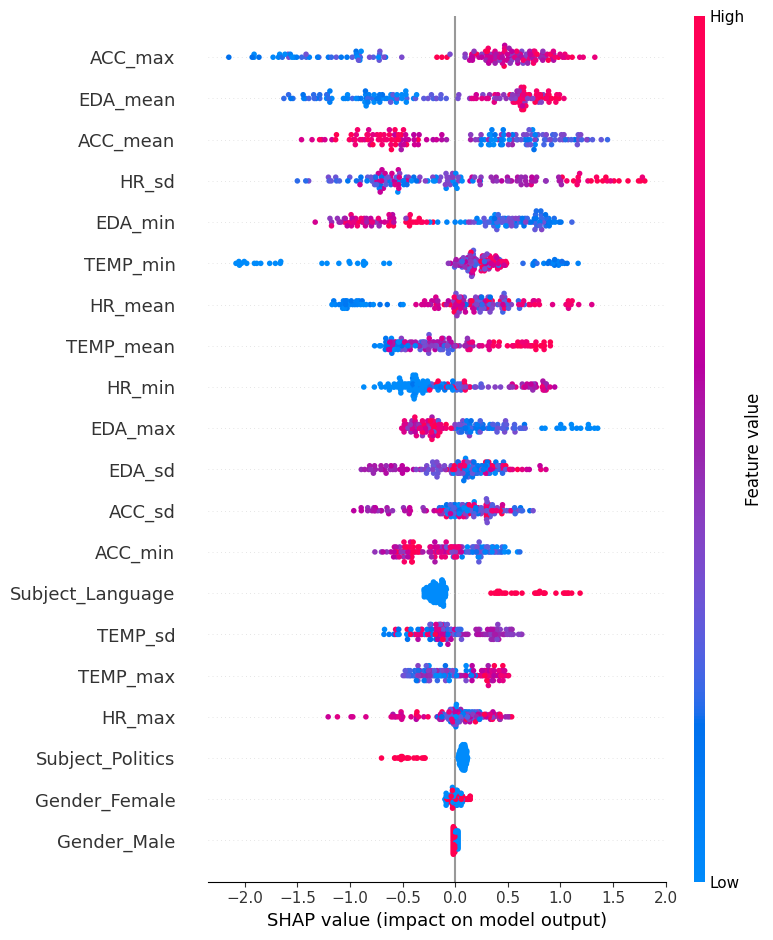

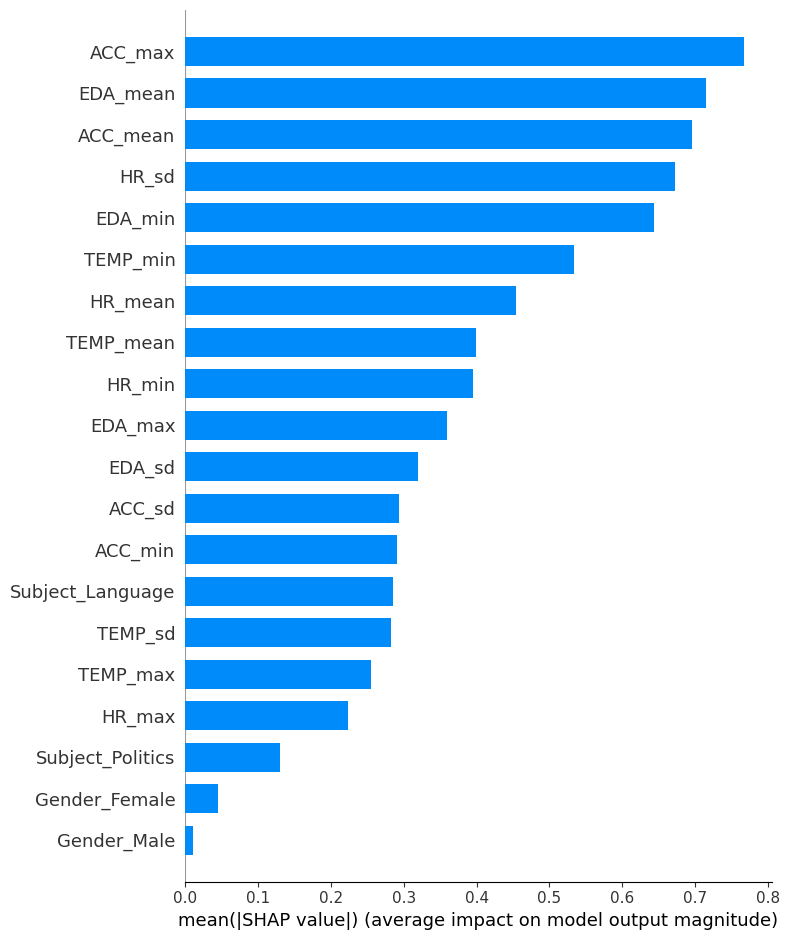

In [ ]:
# =========================================
# SHAP analysis for Engagement vs. Disengagement
# =========================================
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import shap
import numpy as np

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

# Prepare data (exclude Neutral predictions)
df_3 = df_2[df_2["y_pred"] != "neutral"]

# Binary label mapping
mapping = {"engagement": 1, "disengagement": 0}

feature_cols = [
    "Gender", "Subject",
    "HR_mean", "HR_sd", "HR_max", "HR_min",
    "ACC_mean", "ACC_sd", "ACC_max", "ACC_min",
    "EDA_mean", "EDA_sd", "EDA_max", "EDA_min",
    "TEMP_mean", "TEMP_sd", "TEMP_max", "TEMP_min"
]

target_col = "y_pred"

df_3_train = df_3.copy()
df_3_train["y_pred"] = df_3_train["y_pred"].map(mapping)

X = df_3_train[feature_cols]
y = df_3_train[target_col]

# One-hot encoding for categorical variables
X = pd.get_dummies(X, columns=["Gender", "Subject"], prefix=["Gender", "Subject"])

# Train LightGBM model
train_data = lgb.Dataset(X, y)

params = {
    "objective": "binary",
    "metric": "binary_error",
    "boosting_type": "gbdt",
    "learning_rate": 0.1,
    "num_leaves": 31,
    "verbose": -1
}

model = lgb.train(params, train_data, num_boost_round=200)

# Model evaluation
y_pred_prob = model.predict(X)
y_pred_binary = (y_pred_prob >= 0.5).astype(int)

accuracy = accuracy_score(y, y_pred_binary)
precision = precision_score(y, y_pred_binary)
recall = recall_score(y, y_pred_binary)
f1 = f1_score(y, y_pred_binary)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y, y_pred_binary))

print("\nClassification Report:")
print(classification_report(
    y, y_pred_binary,
    target_names=["Disengagement", "Engagement"]
))

# =========================================
# SHAP visualization (correct predictions only)
# =========================================
mask_correct = (y_pred_binary == y)
X_true = X[mask_correct]
y_true = y[mask_correct]

explainer = shap.TreeExplainer(model)
shap_values = explainer(X_true)

# SHAP summary plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_true, show=True)

# SHAP bar plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_true, plot_type="bar", show=True)
